In [4]:

from astroquery.gaia import Gaia
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.login(user='mtauraso', password='o>th2vNGf#p@y6?#')

def query_gaia():

    fields_of_interest = f"""--
    source_id,
    pm,
    pmra,
    pmdec,
    parallax,
    parallax_error,
    parallax_over_error,
    phot_g_mean_mag,
    astrometric_n_obs_ac,
    astrometric_n_obs_al,
    pseudocolour
    """

    query = f"""
    SELECT 
    --TOP 100000
    {fields_of_interest}
    FROM {Gaia.MAIN_GAIA_TABLE}
    --JOIN external.gaiaedr3_distance as d USING (source_id) -- For Bailer-Jones Distances
    --JOIN gaiadr3.astrophysical_parameters as ap USING (source_id) -- For Extinction in all bands
    WHERE 
        astrometric_params_solved = 95 AND
        phot_g_mean_mag is not NULL AND
        random_index BETWEEN 0 AND 1000000
    """
    job = Gaia.launch_job_async(query, verbose = True)
    r = job.get_results()
    r.info()
    return r

data = query_gaia()
    

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
Launched query: '
    SELECT 
    --TOP 100000
    --
    source_id,
    pm,
    pmra,
    pmdec,
    parallax,
    parallax_error,
    parallax_over_error,
    phot_g_mean_mag,
    astrometric_n_obs_ac,
    astrometric_n_obs_al,
    pseudocolour
    
    FROM gaiadr3.gaia_source
    --JOIN external.gaiaedr3_distance as d USING (source_id) -- For Bailer-Jones Distances
    --JOIN gaiadr3.astrophysical_parameters as ap USING (source_id) -- For Extinction in all bands
    WHERE 
        astrometric_params_solved = 95 AND
        phot_g_mean_mag is not NULL AND
        random_index BETWEEN 0 AND 1000000
    '
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = application/x-www-form-urlencoded
303 303
[('Date', 'Fri, 03 Mar 2023 01:24:39 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips mod_jk/1.2.43'), ('Cache-Control', 'no-cach

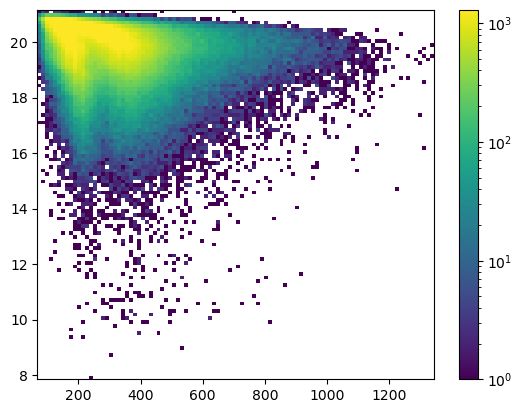

In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

plt.hist2d(data['astrometric_n_obs_al'], data['phot_g_mean_mag'], bins=(100,100), norm=colors.LogNorm(1,1300))
plt.colorbar()
plt.show()

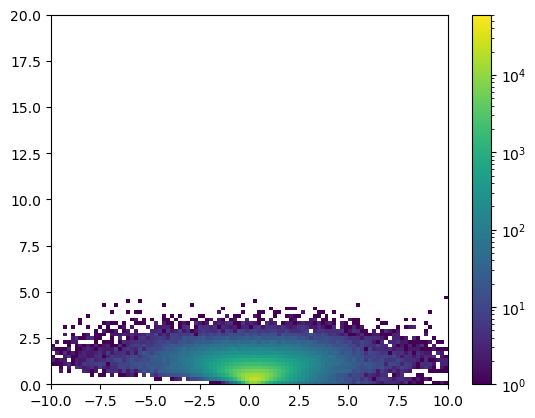

In [36]:
plt.hist2d(data['parallax'], data['parallax_error'], bins=(100,100), range=((-10,10), (0,20)), norm=colors.LogNorm(1,60000))
plt.colorbar()
plt.show()

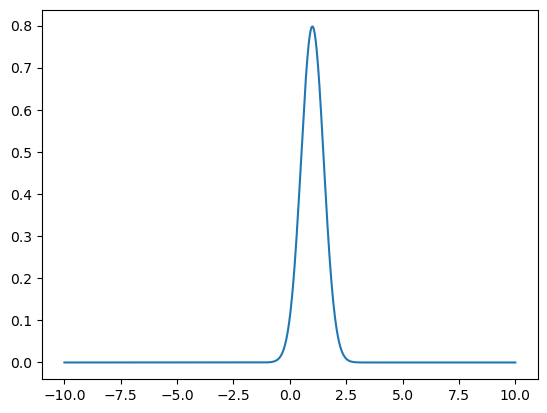

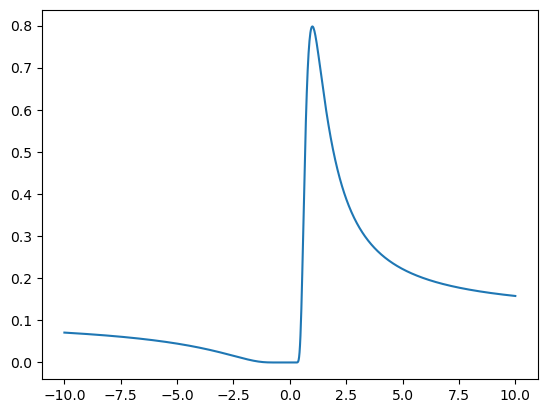

In [37]:
x = np.linspace(-10,10,1000)
sigma = 0.5 # 1mas of error
mean = 1 #1 kpc

gaussian = ((sigma*np.sqrt(2*np.pi))**-1) * np.exp(-((x-mean)/sigma)**2/2)

plt.plot(x, gaussian)
plt.show()

gaussian_dist = ((sigma*np.sqrt(2*np.pi))**-1) * np.exp(-(((1/x)-mean)/sigma)**2/2)

plt.plot(x, gaussian_dist)
plt.show()




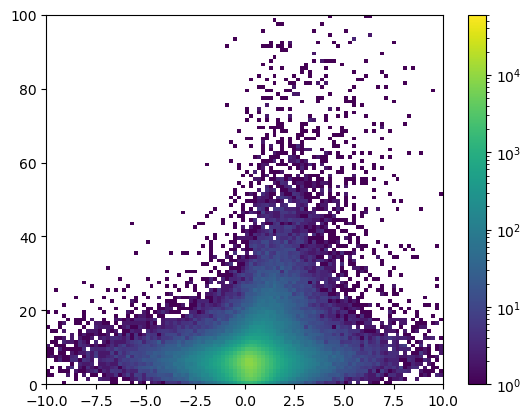

In [38]:
plt.hist2d(data['parallax'], data['pm'], bins=(100,100), range=((-10,10), (0,100)), norm=colors.LogNorm(1,60000))
plt.colorbar()
plt.show()

152922
331450


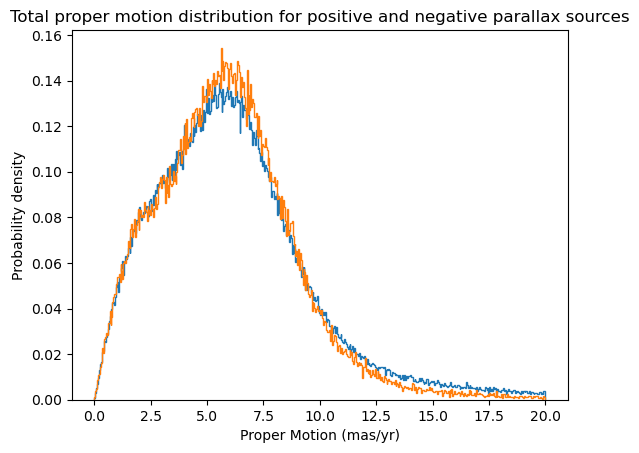

In [39]:
# proper motion for positive parallax

positive_parallax = np.less(data['parallax'], 0)
negative_parallax = np.logical_not(positive_parallax)

print(np.count_nonzero(positive_parallax))
print(np.count_nonzero(negative_parallax))

plt.title("Total proper motion distribution for positive and negative parallax sources")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pm'], mask = positive_parallax).compressed(), bins = 500, range=(0,20), density=True, histtype='step')
plt.hist(np.ma.masked_array(data['pm'], mask = negative_parallax).compressed(), bins = 500, range=(0,20), density=True, histtype='step')
plt.show()

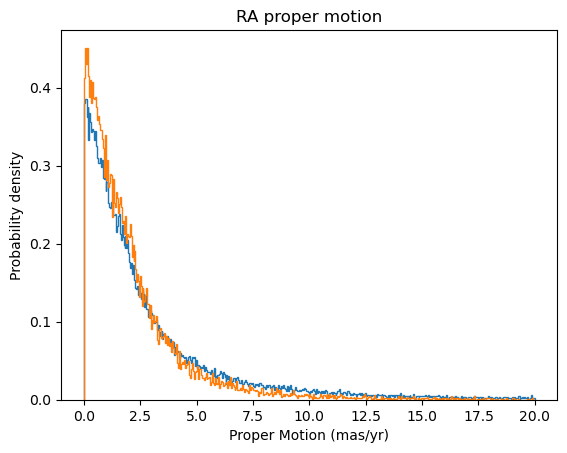

In [40]:
plt.title("RA proper motion")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pmra'], mask = positive_parallax).compressed(), bins = 500, range=(0,20), density=True, histtype='step')
plt.hist(np.ma.masked_array(data['pmra'], mask = negative_parallax).compressed(), bins = 500, range=(0,20), density=True, histtype='step')
plt.show()

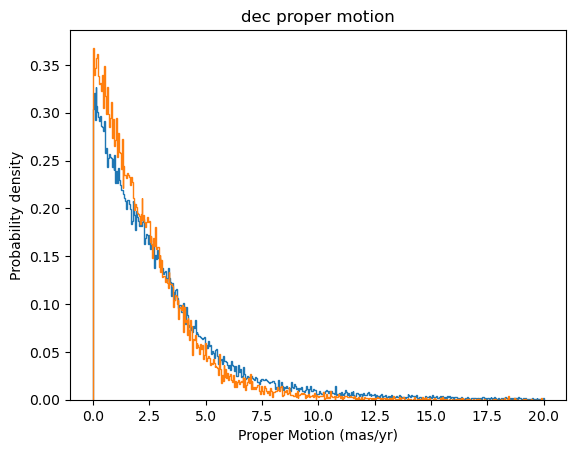

In [41]:
plt.title("dec proper motion")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pmdec'], mask = positive_parallax).compressed(), bins = 500, range=(0,20), density=True, histtype='step')
plt.hist(np.ma.masked_array(data['pmdec'], mask = negative_parallax).compressed(), bins = 500, range=(0,20), density=True, histtype='step')
plt.show()

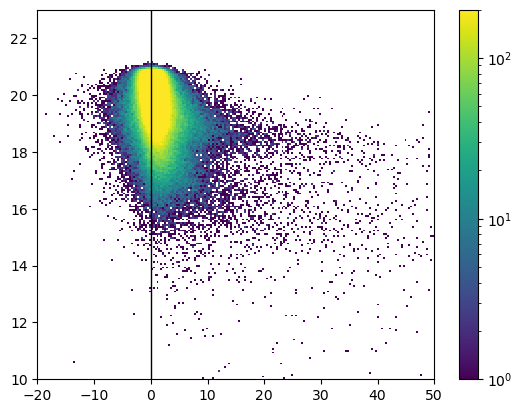

In [42]:
#plt.hexbin(data['parallax'], data['parallax_error'], data['phot_g_mean_mag'],  bins=(1000,1000), extent=(-10,10,0,20), reduce_C_function=np.median)
#plt.colorbar()
from matplotlib.path import Path
import matplotlib.patches as patches
fig, ax = plt.subplots()

plt.hist2d(data['parallax_over_error'], data['phot_g_mean_mag'], bins=(200,200), range=((-20,50), (10,23)) , norm=colors.LogNorm(1,200))
plt.colorbar()

ax.add_patch(patches.PathPatch(Path([(0,10),(0,25)]), fill=False))
plt.show()

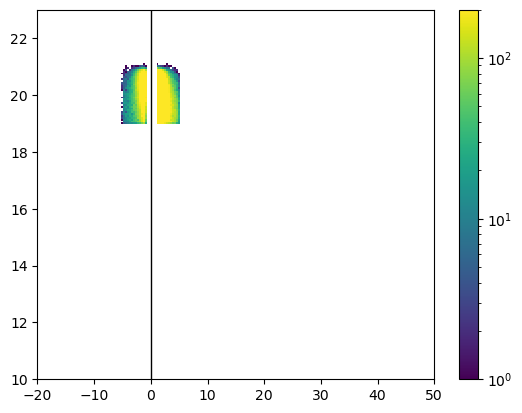

In [43]:
dim_mask = np.less(data['phot_g_mean_mag'], 19)
uncertain_mask = np.greater(np.abs(data['parallax_over_error']), 5)
certain_mask = np.less(np.abs(data['parallax_over_error']), 1)

dim_and_uncertain_mask = np.logical_or(dim_mask, uncertain_mask)
dim_and_certain_mask = np.logical_or(dim_and_uncertain_mask, certain_mask)

fig, ax = plt.subplots()

plt.hist2d(np.ma.masked_array(data['parallax_over_error'], mask=dim_and_certain_mask).compressed(), 
           np.ma.masked_array(data['phot_g_mean_mag'], mask=dim_and_certain_mask).compressed(), 
           bins=(200,200), range=((-20,50), (10,23)) , norm=colors.LogNorm(1,200))
plt.colorbar()

ax.add_patch(patches.PathPatch(Path([(0,10),(0,25)]), fill=False))
plt.show()

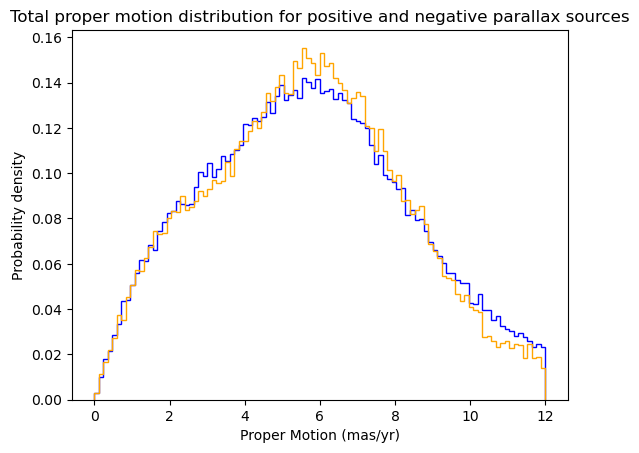

In [44]:
plt.title("Total proper motion distribution for positive and negative parallax sources")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pm'], mask = np.logical_or(positive_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(0,12), density=True, histtype='step', color="blue")
plt.hist(np.ma.masked_array(data['pm'], mask = np.logical_or(negative_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(0,12), density=True, histtype='step', color="orange")
plt.show()

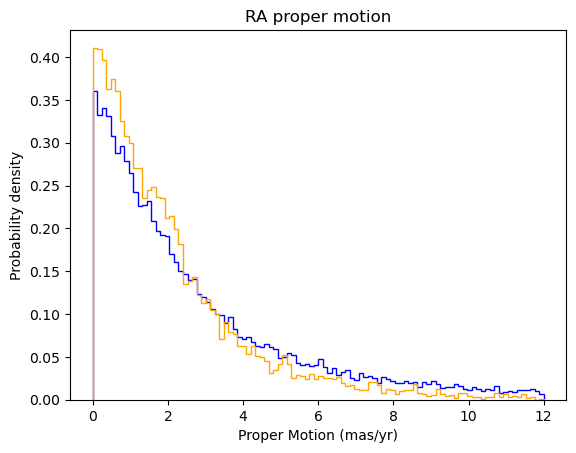

In [45]:
plt.title("RA proper motion")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pmra'], mask = np.logical_or(positive_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(0,12), density=True, histtype='step', color="blue")
plt.hist(np.ma.masked_array(data['pmra'], mask = np.logical_or(negative_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(0,12), density=True, histtype='step', color="orange")

plt.show()

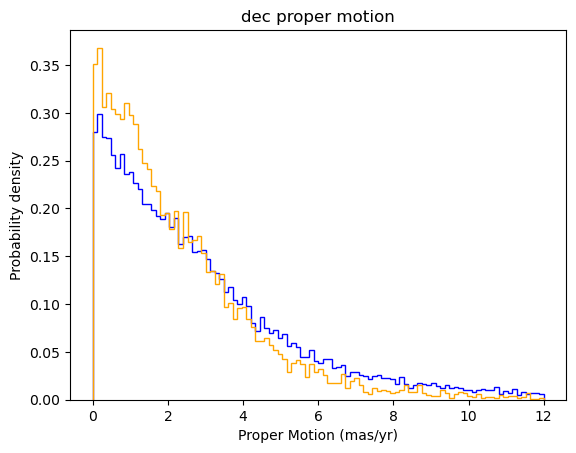

In [46]:
plt.title("dec proper motion")
plt.xlabel("Proper Motion (mas/yr)")
plt.ylabel("Probability density")

plt.hist(np.ma.masked_array(data['pmdec'], mask = np.logical_or(positive_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(0,12), density=True, histtype='step', color="blue")
plt.hist(np.ma.masked_array(data['pmdec'], mask = np.logical_or(negative_parallax, dim_and_certain_mask)).compressed(), bins = 100, range=(0,12), density=True, histtype='step', color="orange")
plt.show()

In [47]:
len(data)

484372